In [224]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [225]:
df_features = pd.read_csv(filepath_or_buffer='training_data/landmarks.csv',
                 index_col='pose_id')

df_features.head()

,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,x_left_eye_outer,...,z_left_heel,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index
pose_id,,,,,,,,,,,,,,,,,,,,,
0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,-2.032406,...,56.852562,-0.842025,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795
1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,-1.494903,...,-14.129170,-1.298891,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056
2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,-0.019743,...,-19.904400,-2.119770,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527
3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,-1.753780,...,-6.855729,-1.485475,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043
4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,0.969290,...,47.124107,-2.455719,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315


In [226]:
df_labels = pd.read_csv(filepath_or_buffer='training_data/labels.csv',
                        index_col='pose_id')
df_labels.head()

,pose
pose_id,
0,jumping_jacks_down
1,jumping_jacks_down
2,jumping_jacks_down
3,jumping_jacks_down
4,jumping_jacks_down


In [227]:
X = df_features.values
y = pd.get_dummies(df_labels, dtype=int).values

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=38, stratify=y)

In [229]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [230]:
type(X_train)

numpy.ndarray

In [231]:
model = Sequential([
    Input(shape=(99,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,426 (142.29 KB)

 Trainable params: 36,298 (141.79 KB)

 Non-trainable params: 128 (512.00 B)

In [232]:
def stop_early(check, patience=10):
    earlystopping=EarlyStopping(patience=patience,
                                restore_best_weights=True,
                                monitor=check,
                                mode='max',
                                start_from_epoch=50)
    return earlystopping

In [233]:
model.compile(optimizer='adam', metrics=['f1_score'], loss='categorical_focal_crossentropy')
model.fit(X_train, y_train, epochs=55, validation_split=0.1)

Epoch 1/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - f1_score: 0.1933 - loss: 0.4201 - val_f1_score: 0.2081 - val_loss: 0.4082
Epoch 2/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.4933 - loss: 0.2247 - val_f1_score: 0.4465 - val_loss: 0.3277
Epoch 3/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.7265 - loss: 0.1137 - val_f1_score: 0.6233 - val_loss: 0.2250
Epoch 4/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.7925 - loss: 0.0685 - val_f1_score: 0.7639 - val_loss: 0.1759
Epoch 5/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.8357 - loss: 0.0584 - val_f1_score: 0.7240 - val_loss: 0.1453
Epoch 6/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.7976 - loss: 0.0584 - val_f1_score: 0.7388 - val_loss: 0.1509
Epoch 7/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.7887 - loss: 0.0488 - val_f1_score: 0.7207 - val_loss: 0.1389
Epoch 8/55
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.8534 - loss: 0.0412 - val_f1_score: 0.6999 - val_loss:

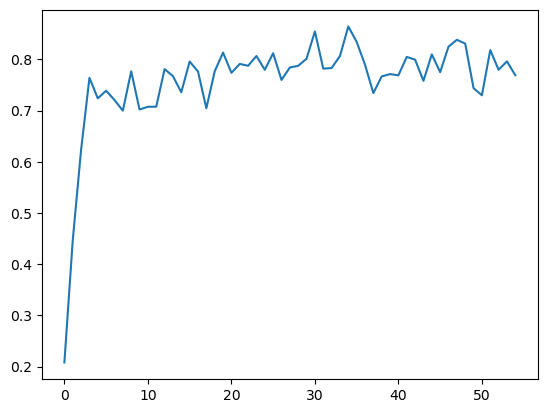

In [234]:
plt.plot(range(0,55),np.mean(model.history.history['val_f1_score'], axis=1))

In [235]:
y_res = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [240]:
def get_highest_threshold(testX, model):
    y_pred = model.predict(testX)
    y_res = np.argmax(y_pred, axis=1)
    max_threshold = 0
    nb_false = {}
    for threshold in np.linspace(0.05,0.95,500):
        y_threshold = np.argmax((y_pred > threshold).astype(int), axis=1)
        comparison = [a == b for a,b in zip(y_threshold, y_res)]
        nb_false[threshold] = comparison.count(False) / y_res.shape[0]
        # if all(comparison) and max_threshold < threshold:
        #     max_threshold = threshold
    return nb_false

In [241]:
seuil_maximal = get_highest_threshold(X_test, model=model)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [242]:
seuil_maximal

{0.05: 0.36151603498542273,
 0.05180360721442886: 0.3556851311953353,
 0.05360721442885772: 0.35276967930029157,
 0.055410821643286576: 0.34110787172011664,
 0.05721442885771543: 0.33819241982507287,
 0.059018036072144286: 0.3294460641399417,
 0.06082164328657315: 0.32653061224489793,
 0.06262525050100201: 0.3236151603498542,
 0.06442885771543086: 0.3206997084548105,
 0.06623246492985972: 0.3177842565597668,
 0.06803607214428858: 0.3177842565597668,
 0.06983967935871743: 0.31486880466472306,
 0.0716432865731463: 0.30903790087463556,
 0.07344689378757516: 0.30612244897959184,
 0.075250501002004: 0.30612244897959184,
 0.07705410821643287: 0.30612244897959184,
 0.07885771543086173: 0.3032069970845481,
 0.08066132264529058: 0.3032069970845481,
 0.08246492985971944: 0.3032069970845481,
 0.0842685370741483: 0.30029154518950435,
 0.08607214428857715: 0.30029154518950435,
 0.08787575150300601: 0.30029154518950435,
 0.08967935871743488: 0.30029154518950435,
 0.09148296593186372: 0.3002915451895

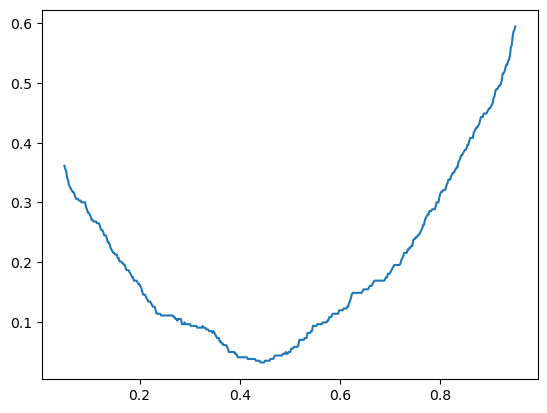

In [243]:
plt.plot(seuil_maximal.keys(), seuil_maximal.values())